In [1]:
print("Starting with Deep Learning")

Starting with Deep Learning


In [2]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [3]:
import numpy as np
import pathlib
import struct
import pandas as pd
import gc
import os.path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tabulate import tabulate
import csv

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

print("Done")

Done


In [4]:
print(len(tf.config.list_physical_devices('GPU')))

1


In [5]:
### Usable Files

direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Filtered/Processed/")

# direction = pathlib.Path("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Detector97/Unfiltered/Processed/")

file_list = list(direction.iterdir())

file_num = len(file_list)

step = 0.8

num_test_files = 2
eighty = round(step*file_num)
twenty = file_num-eighty - num_test_files

list_of_file_ids_train = np.arange(eighty, dtype=int)
print(list_of_file_ids_train)
list_of_file_ids_val = np.arange(eighty,eighty+twenty-num_test_files, dtype=int)
print(list_of_file_ids_val)
list_of_file_ids_test =np.arange(file_num-num_test_files,file_num)
print(list_of_file_ids_test)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[32 33 34 35]
[38 39]


In [6]:

##### Functions to process the data

        ### Unnormalization of each signal individually
def Unnormalized(batch_signals):
        
        return batch_signals
        
        ### Normalization of each signal individually
def Normalized(batch_signals):

        for i in range(len(batch_signals)):
            batch_signals[i] = batch_signals[i]/np.max(batch_signals[i])
            
        return batch_signals
            
        
        ### Normalization of the entire value by one common denominator      
def Denominator(batch_signals):  
    
        denominator = 3953.48
        batch_signals = batch_signals/denominator
        
        return batch_signals


##### Class



class TrainDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Train Class')
        if(file_id == 0):
#             print("reshuffling")
            np.random.shuffle(list_of_file_ids_train)             

        i_file = list_of_file_ids_train[file_id]

#         print(f'file_id: {file_id}, i_file: {i_file}')
#         print()
        signal_filename = direction/f'{i_file+1}.h5'

        
         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)    
        
        labels = df[variable]
        signals = df[df.columns[10:-2]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels.iloc[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels.values 
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1998,1), (batch_size, )),
            args=(file_id,)
        )

class ValDataset(tf.data.Dataset):

    def _generator(file_id):  
#         print(f'Using Val Class')
        i_file = list_of_file_ids_val[file_id]
    
        signal_filename = direction/f'{i_file+1}.h5'

         # Load the labels and signals from the files
        df = pd.read_hdf(signal_filename,key=None)    
        
        labels = df[variable]
        signals = df[df.columns[10:-2]].values
        
        
        # Determine how many batches can be made from this file
        num_batches = len(signals) // batch_size

        # Shuffle the signals within the file
        signal_indices = np.arange(len(signals))
        np.random.shuffle(signal_indices)        
        
        # Loop through each batch in the file
        for batch_idx in range(num_batches):
            # Get the signals and labels for this batch
            batch_signal_indices = signal_indices[batch_idx*batch_size:(batch_idx+1)*batch_size]      
 
            batch_signals = signals[batch_signal_indices]
            
            batch_signals = Processing[process](batch_signals)
                
            batch_signals = batch_signals[:,:,np.newaxis] # Can also be done with signals = signals[:,:,np.newaxis]
            batch_labels = labels.iloc[batch_signal_indices]

            # Yield the signals and labels as a tuple
            yield batch_signals, batch_labels.values 
             
    def __new__(cls, file_id):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float64, tf.dtypes.float64),
            output_shapes=((batch_size, 1998,1), (batch_size, )),
            args=(file_id,)
        )

In [7]:
def create_model():
    model = keras.models.Sequential()
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(1998, 1)))
    model.add(Conv1D(filters=8, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=5, dilation_rate=2, activation='relu'))
    model.add(Conv1D(filters=4, kernel_size=5, strides=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=4, kernel_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

In [8]:
# Pre-processing options
Processing = {
    "Unnormalized": Unnormalized,
    "Normalized": Normalized,
    "Denominator": Denominator
}
Process = ["Unnormalized","Normalized","Denominator"]
process = Process[1]
# Loss Function

loss_function = ['mean_absolute_error','mean_squared_error']
lf = 1

# Training Variables
batch_size = 32
num_epochs = 30

steps_per_epoch = eighty*5000 // batch_size

# Learning Rate
initial_lr = 1e-03
final_lr = 1e-06

# initial_lr = 1e-03
# final_lr = 1e-03

def step_decay(epoch):
    lrate = initial_lr * (final_lr/initial_lr)**(epoch/num_epochs)

    print(f'Current Learning rate: {lrate}')
    return lrate

# Compile the model
# model.compile(loss=loss_function[lf], optimizer = keras.optimizers.Adam(initial_lr), metrics=['mean_absolute_error','mean_squared_error'])

# Configuring training dataset
dataset_train = tf.data.Dataset.range(eighty).interleave(
        TrainDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).repeat().prefetch(1)



# Configuring training dataset
dataset_val = tf.data.Dataset.range(twenty-num_test_files).interleave(
        ValDataset,
        cycle_length=2,
        num_parallel_calls=2,
        deterministic=True).prefetch(1)


# Callback Functions
LRS = tf.keras.callbacks.LearningRateScheduler(step_decay)

ES = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True,verbose=1)

CSV = tf.keras.callbacks.CSVLogger("C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Data/Log.csv",
                                separator=",", append=True)

MC_path = f"C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/model_checkpoint.h5"
MC = ModelCheckpoint(
    filepath=MC_path,  # Filepath to save the model weights
    monitor='val_loss',  # Quantity to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model based on the monitored quantity
    save_weights_only=True  # Save only the model weights, not the entire model
)

callbacks = [MC,LRS,CSV]



# Variable of interest
variable = 'PDT'



Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [9]:
num_runs = 5  # Number of times to run the model

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    model = create_model()
    
    model.compile(loss=loss_function[lf], optimizer = keras.optimizers.Adam(initial_lr), metrics=['mean_absolute_error','mean_squared_error'])
    
    MC_path = f"C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/model_checkpoint_{run + 1}.h5"
    MC = ModelCheckpoint(
    filepath=MC_path,  # Filepath to save the model weights
    monitor='val_loss',  # Quantity to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model based on the monitored quantity
    save_weights_only=True  # Save only the model weights, not the entire model
    )

    callbacks = [MC,LRS,CSV]
    
    # Train the model
    history = model.fit(x=dataset_train, validation_data = dataset_val, steps_per_epoch=steps_per_epoch, epochs=num_epochs,callbacks=callbacks)

Run 1/5
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 61s 9ms/step - loss: 0.0306 - mean_absolute_error: 0.1250 - mean_squared_error: 0.0306 - val_loss: 0.0431 - val_mean_absolute_error: 0.1778 - val_mean_squared_error: 0.0431
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 35s 7ms/step - loss: 0.0136 - mean_absolute_error: 0.0877 - mean_squared_error: 0.0136 - val_loss: 0.0642 - val_mean_absolute_error: 0.2307 - val_mean_squared_error: 0.0642
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 39s 8ms/step - loss: 0.0097 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0097 - val_loss: 0.0909 - val_mean_absolute_error: 0.2642 - val_mean_squared_error: 0.0909
Epoch 4/30
Current Learning rate: 0.0005011872336272722
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0080 - mean_absolute_error: 0.0691 - mean_squared_error: 0.008

Run 2/5
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 43s 8ms/step - loss: 0.0555 - mean_absolute_error: 0.1558 - mean_squared_error: 0.0555 - val_loss: 36.0546 - val_mean_absolute_error: 5.9966 - val_mean_squared_error: 36.0546
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0217 - mean_absolute_error: 0.1061 - mean_squared_error: 0.0217 - val_loss: 0.0212 - val_mean_absolute_error: 0.1235 - val_mean_squared_error: 0.0212
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 42s 8ms/step - loss: 0.0087 - mean_absolute_error: 0.0715 - mean_squared_error: 0.0087 - val_loss: 0.0208 - val_mean_absolute_error: 0.1157 - val_mean_squared_error: 0.0208
Epoch 4/30
Current Learning rate: 0.0005011872336272722
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0064 - mean_absolute_error: 0.0615 - mean_squared_error: 0.0

Run 3/5
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 41s 8ms/step - loss: 0.0221 - mean_absolute_error: 0.1049 - mean_squared_error: 0.0221 - val_loss: 0.4625 - val_mean_absolute_error: 0.6042 - val_mean_squared_error: 0.4625
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0080 - mean_absolute_error: 0.0688 - mean_squared_error: 0.0080 - val_loss: 0.3793 - val_mean_absolute_error: 0.6009 - val_mean_squared_error: 0.3793
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 40s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0590 - mean_squared_error: 0.0060 - val_loss: 0.1427 - val_mean_absolute_error: 0.3018 - val_mean_squared_error: 0.1427
Epoch 4/30
Current Learning rate: 0.0005011872336272722
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0546 - mean_squared_error: 0.005

Run 4/5
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 40s 7ms/step - loss: 0.0454 - mean_absolute_error: 0.1354 - mean_squared_error: 0.0454 - val_loss: 0.8579 - val_mean_absolute_error: 0.9177 - val_mean_squared_error: 0.8579
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 33s 7ms/step - loss: 0.0198 - mean_absolute_error: 0.1064 - mean_squared_error: 0.0198 - val_loss: 5.6926 - val_mean_absolute_error: 2.3716 - val_mean_squared_error: 5.6926
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 40s 8ms/step - loss: 0.0159 - mean_absolute_error: 0.0929 - mean_squared_error: 0.0159 - val_loss: 0.2252 - val_mean_absolute_error: 0.4517 - val_mean_squared_error: 0.2252
Epoch 4/30
Current Learning rate: 0.0005011872336272722
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0094 - mean_absolute_error: 0.0744 - mean_squared_error: 0.009

5000/5000 [==============================] - 36s 7ms/step - loss: 0.0046 - mean_absolute_error: 0.0504 - mean_squared_error: 0.0046 - val_loss: 0.0044 - val_mean_absolute_error: 0.0496 - val_mean_squared_error: 0.0044
Run 5/5
Epoch 1/30
Current Learning rate: 0.001
5000/5000 [==============================] - 42s 7ms/step - loss: 0.0293 - mean_absolute_error: 0.1167 - mean_squared_error: 0.0293 - val_loss: 0.4797 - val_mean_absolute_error: 0.6802 - val_mean_squared_error: 0.4797
Epoch 2/30
Current Learning rate: 0.0007943282347242815
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0787 - mean_squared_error: 0.0108 - val_loss: 0.0089 - val_mean_absolute_error: 0.0744 - val_mean_squared_error: 0.0089
Epoch 3/30
Current Learning rate: 0.0006309573444801933
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0622 - mean_squared_error: 0.0065 - val_loss: 0.0242 - val_mean_absolute_error: 0.1226 -

Epoch 30/30
Current Learning rate: 1.2589254117941674e-06
5000/5000 [==============================] - 51s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0028 - val_loss: 0.0027 - val_mean_absolute_error: 0.0399 - val_mean_squared_error: 0.0027


Train Lowest: 0.0028110789135098457
Val Lowest: 0.0026801072526723146


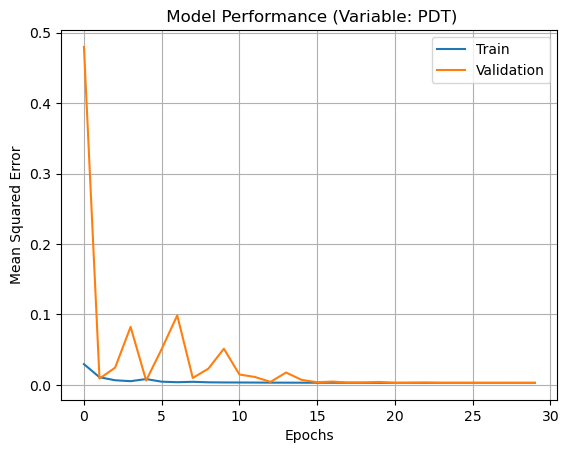

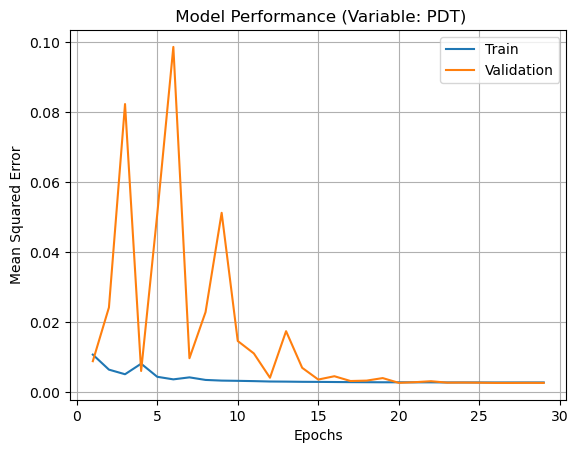

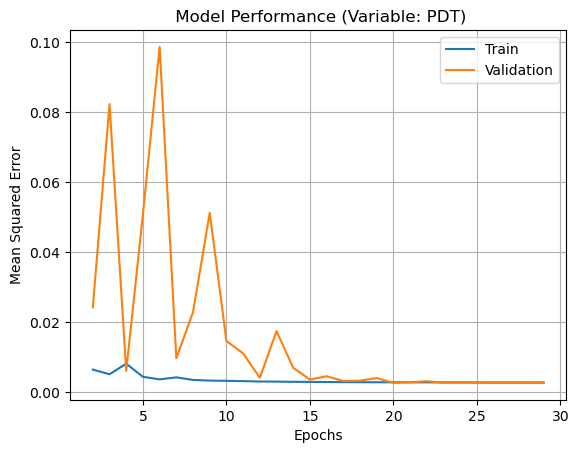

In [10]:
##### All Analysis Tools:::

# Loss/Val vs Epochs
loss = history.history['loss']
val = history.history['val_loss']

x1 = np.arange(1,len(loss))
x2 = np.arange(2,len(loss))

# print(f'Training: {loss} \n')
# print(f'Validation: {val}')

print(f'Train Lowest: {loss[-1]}')
print(f'Val Lowest: {val[-1]}')

# Full Training
plt.plot(loss,label='Train')
plt.title(f' Model Performance (Variable: PDT)')
plt.plot(val,label='Validation')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full training without first epoch
plt.plot(x1,loss[1:],label='Train')
plt.plot(x1,val[1:],label='Validation')
plt.title(f' Model Performance (Variable: PDT)')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# Full training without first two epochs
plt.plot(x2,loss[2:],label='Train')
plt.plot(x2,val[2:],label='Validation')
plt.title(f' Model Performance (Variable: PDT)')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

In [11]:
MC_path = f"C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/PDT/model_checkpoint_5.h5"
model = create_model()
model.load_weights(MC_path)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:/Users/steve/OneDrive/Bureaublad/Studies/Thesis/Trainings/PDT/model_checkpoint_5.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
avg_loss = []

for i in list_of_file_ids_test:
    # Load the data and perform necessary preprocessing steps
    df = pd.read_hdf(file_list[i], key=None)
    labels = df['PDT']
    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    # Make predictions using the trained model
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    # Calculate the test loss
    test_loss = np.subtract(predicted, true)
    avg_test_loss = np.mean(np.abs(test_loss))
    avg_loss.append(avg_test_loss)

# Calculate the mean and standard deviation of the average test loss
mean_loss = np.mean(avg_loss)
std_loss = np.std(avg_loss)

print(f"Mean Absolute Error: {mean_loss}")
print(f"Standard Deviation: {std_loss}")

In [ ]:
avg_loss = []

for i in list_of_file_ids_test:
    # Load the data and perform necessary preprocessing steps
    df = pd.read_hdf(file_list[i], key=None)
    labels = df['PDT']
    signals = df[df.columns[10:-2]].values
    signals = Processing[process](signals)
    signals = signals[:, :, np.newaxis]

    # Make predictions using the trained model
    predicted = model.predict(signals)
    predicted = np.squeeze(predicted)
    true = labels

    # Calculate the test loss
    test_loss = np.subtract(predicted, true)

    # Calculate mean squared error (MSE)
    mse = np.mean(np.square(test_loss))
    print("Mean Squared Error:", mse)
    avg_loss.append(mse)

# Calculate the mean and standard deviation of the average MSE
mean_loss = np.mean(avg_loss)
std_loss = np.std(avg_loss)

print(f"Mean Squared Error: {mean_loss}")
print(f"Standard Deviation: {std_loss}")

In [ ]:
df_test = pd.concat([pd.read_hdf(file_list[i], key=None) for i in list_of_file_ids_test])
unique_mass_test = df_test['A'].unique()

result_dict = {}  # Dictionary to store unique_mass and corresponding avg_test_loss values

# Test Set
for mass_test in unique_mass_test:
    print(f"Unique Mass: {mass_test}")
    df_intermediate = df_test[df_test['A'] == mass_test]
    unique_energy = df_intermediate['Z'].unique()

    for energy in unique_energy:
        print(f"Unique Energy: {energy}")
        
        df_combination = df_intermediate[df_intermediate['Z'] == energy]

        labels = df['PDT']

        signals = df_combination[df_combination.columns[10:-2]].values
        signals = Processing[process](signals)
        signals = signals[:, :, np.newaxis]

        predicted = model.predict(signals)
        predicted = np.squeeze(predicted)
        true = labels

        difference = predicted - true

        # Plotting the distribution
        plt.figure()
        plt.hist(difference, bins=20)
        plt.title(f"A={mass_test}, Z={energy}, Count={len(df_combination)}")
        plt.xlabel("Difference (predicted - true)")
        plt.ylabel("Frequency")

        # Calculate mean and standard deviation
        mean = np.mean(difference)
        std = np.std(difference)

        # Create legend text with mean and standard deviation
        legend_text = f"Mean: {mean:.2f}\nSTD: {std:.2f}"

        # Add legend with the mean and standard deviation
        plt.legend([legend_text])

        plt.show()

        avg_test_loss = np.mean(np.abs(difference))
        count = len(df_combination)

        result_dict[(mass_test, energy)] = {
            'avg_test_loss': avg_test_loss,
            'count': count,
            'mean_test_loss': mean,
            'std_test_loss': std
        }

# Print the result dictionary
for (mass, energy), result in result_dict.items():
    avg_test_loss = result['avg_test_loss']
    count = result['count']
    mean_test_loss = result['mean_test_loss']
    std_test_loss = result['std_test_loss']

    print(f"Unique Mass: {mass}, Unique Energy: {energy}")
    print(f"Avg Test Loss: {avg_test_loss}")
    print(f"Count: {count}")
    print(f"Mean Test Loss: {mean_test_loss}")
    print(f"Standard Deviation Test Loss: {std_test_loss}")
    print()